LOADING LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

DATA LOADING

In [3]:
df = pd.read_csv("health-insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
assert df.isnull().sum().sum() == 0, "Dataset contains missing values"

FEATURE SELECTION

In [5]:
X = df.drop("charges", axis=1)
y = np.log1p(df["charges"])

Log transformation was done to avoid data being skewed which will make our charges target influence our model performance

In [6]:
categorical_features = ["sex", "smoker", "region"]
numerical_features = ["age", "bmi", "children"]

In [7]:
preprocessor = ColumnTransformer(
transformers=[
("num", StandardScaler(), numerical_features),
("cat", OneHotEncoder(drop="first"), categorical_features)
]
)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42
)

In [9]:
baseline_pred = np.full(len(y_test), y_train.mean())
baseline_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(baseline_pred)))
baseline_mae = mean_absolute_error(np.expm1(y_test), np.expm1(baseline_pred))
baseline_pred, baseline_rmse, baseline_mae

(array([9.11348876, 9.11348876, 9.11348876, 9.11348876, 9.11348876,
        9.11348876, 9.11348876, 9.11348876, 9.11348876, 9.11348876,
        9.11348876, 9.11348876, 9.11348876, 9.11348876, 9.11348876,
        9.11348876, 9.11348876, 9.11348876, 9.11348876, 9.11348876,
        9.11348876, 9.11348876, 9.11348876, 9.11348876, 9.11348876,
        9.11348876, 9.11348876, 9.11348876, 9.11348876, 9.11348876,
        9.11348876, 9.11348876, 9.11348876, 9.11348876, 9.11348876,
        9.11348876, 9.11348876, 9.11348876, 9.11348876, 9.11348876,
        9.11348876, 9.11348876, 9.11348876, 9.11348876, 9.11348876,
        9.11348876, 9.11348876, 9.11348876, 9.11348876, 9.11348876,
        9.11348876, 9.11348876, 9.11348876, 9.11348876, 9.11348876,
        9.11348876, 9.11348876, 9.11348876, 9.11348876, 9.11348876,
        9.11348876, 9.11348876, 9.11348876, 9.11348876, 9.11348876,
        9.11348876, 9.11348876, 9.11348876, 9.11348876, 9.11348876,
        9.11348876, 9.11348876, 9.11348876, 9.11

MODEL PIPELINES

In [11]:
models = {
"Linear": LinearRegression(),
"Ridge": Ridge(),
"Lasso": Lasso(),
"ElasticNet": ElasticNet(),
"GradientBoosting": GradientBoostingRegressor(random_state=42)
}


param_grids = {
"Ridge": {"model__alpha": [0.1, 1, 10]},
"Lasso": {"model__alpha": [0.01, 0.1, 1]},
"ElasticNet": {
"model__alpha": [0.01, 0.1, 1],
"model__l1_ratio": [0.3, 0.5, 0.7]
},
"GradientBoosting": {
"model__n_estimators": [100, 200],
"model__learning_rate": [0.05, 0.1],
"model__max_depth": [2, 3]
}
}

TRAIN DIFFERENT MODELS

In [12]:
results = {}

for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    # Hyperparameter tuning if grid exists
    if name in param_grids:
        grid = GridSearchCV(
            estimator=pipe,
            param_grid=param_grids[name],
            cv=5,
            scoring="r2",
            n_jobs=-1
        )
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
    else:
        best_model = pipe.fit(X_train, y_train)

    # Predictions (log space)
    y_pred = best_model.predict(X_test)

    # Convert back to original scale
    y_test_actual = np.expm1(y_test)
    y_pred_actual = np.expm1(y_pred)

    # Metrics
    results[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_test_actual, y_pred_actual)),
        "MAE": mean_absolute_error(y_test_actual, y_pred_actual),
        "R2": r2_score(y_test, y_pred),  # R² stays in log space
        "Model": best_model
    }


CHOOSE BEST MODEL USING RMSE

In [13]:
#Select Best Model 
best_name = min(results, key=lambda x: results[x]["RMSE"])
best_model = results[best_name]["Model"]

#Explainability 
model = best_model.named_steps["model"]

# Extract feature names safely
num_features = numerical_features

cat_features = list(
    best_model.named_steps["preprocessor"]
    .named_transformers_["cat"]
    .get_feature_names_out(categorical_features)
)

feature_names = num_features + cat_features

# Model-specific importance handling
if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_

elif hasattr(model, "coef_"):
    importances = np.abs(model.coef_)

else:
    raise ValueError(
        f"Model type {type(model).__name__} does not support feature importance"
    )

# Build feature importance dataframe
fi = (
    pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    })
    .sort_values("Importance", ascending=False)
    .reset_index(drop=True)
)


RESIDUAL PLOT ANALYSIS

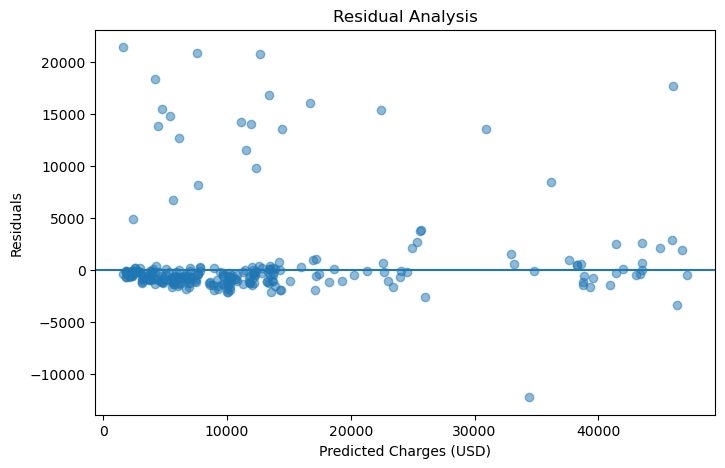

In [14]:
y_pred_best = np.expm1(best_model.predict(X_test))
residuals = y_test_actual - y_pred_best


plt.figure(figsize=(8,5))
plt.scatter(y_pred_best, residuals, alpha=0.5)
plt.axhline(0)
plt.xlabel("Predicted Charges (USD)")
plt.ylabel("Residuals")
plt.title("Residual Analysis")
plt.show()

In [15]:
final_metrics = pd.DataFrame(results).T[["RMSE", "MAE", "R2"]]
final_metrics

,RMSE,MAE,R2
Linear,7814.064026,3888.443159,0.804741
Ridge,7807.925008,3887.297915,0.804729
Lasso,7411.527311,3834.267743,0.795959
ElasticNet,7346.895448,3821.296373,0.8003
GradientBoosting,4404.556992,1965.877847,0.865041


In [16]:
#saving the best model
import joblib
joblib.dump(best_model, "best_health_insurance_model.pkl")  

['best_health_insurance_model.pkl']

In [17]:
#make predictions for the dataset, combine with original data, actual and predicted charges
df_test = X_test.copy()
df_test["Actual Charges"] = y_test_actual
df_test["Predicted Charges"] = y_pred_best
df_test.head()

,age,sex,bmi,children,smoker,region,Actual Charges,Predicted Charges
764,45,female,25.175,2,no,northeast,9095.06825,9704.877589
887,36,female,30.020,0,no,northwest,5272.17580,5936.161538
890,64,female,26.885,0,yes,northwest,29330.98315,25558.343778
1293,46,male,25.745,3,no,northwest,9301.89355,9477.143970
259,19,male,31.920,0,yes,northwest,33750.29180,33190.255639


In [18]:
#save df_test to csv
df_test.to_csv("health_insurance_predictions.csv", index=False)

In [19]:
insurance_test=pd.read_csv("C:/Users/lesson/OneDrive/Desktop/ALL ML PROJECTS/insurance.csv")
insurance_test.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [20]:
insurance_df=insurance_test.drop(columns="charges")
insurance_df.head()

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


In [21]:
insurance_df.to_csv("health_insurance_test_data_df.csv", index=False)  